In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpyro
import numpyro.distributions as dist
import polars as pl
import seaborn as sns
from flax import linen as nn
from jax import random
from numpyro.contrib.module import random_flax_module
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.infer.util import Predictive
from scipy.special import logit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MaxAbsScaler,
    OneHotEncoder,
    StandardScaler,
)

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [23]:
raw_df = pl.read_csv(
    "../data/online_retail_II.csv",
    columns=[
        "Customer ID",
        "InvoiceDate",
        "Quantity",
        "Price",
        "Country",
    ],
    try_parse_dates=True,
)

raw_df.head()

Quantity,InvoiceDate,Price,Customer ID,Country
i64,datetime[μs],f64,f64,str
12,2009-12-01 07:45:00,6.95,13085.0,"""United Kingdom…"
12,2009-12-01 07:45:00,6.75,13085.0,"""United Kingdom…"
12,2009-12-01 07:45:00,6.75,13085.0,"""United Kingdom…"
48,2009-12-01 07:45:00,2.1,13085.0,"""United Kingdom…"
24,2009-12-01 07:45:00,1.25,13085.0,"""United Kingdom…"


In [24]:
raw_df.shape

(1067371, 5)

In [144]:
cleaned_transactions_df = (
    raw_df.select(pl.all().name.to_lowercase())
    .select(pl.all().name.map(lambda s: s.replace(" ", "_")))
    .filter(pl.col("customer_id").is_not_null())
    .sort(["country", "customer_id", "invoicedate"])
    .with_columns(
        pl.col("customer_id").cast(pl.Int64),
        revenue=pl.col("quantity") * pl.col("price"),
        cohort=(
            pl.col("invoicedate").sort().first().over("customer_id").dt.truncate("1mo")
        ),
        period=pl.col("invoicedate").dt.truncate("1mo"),
    )
    .filter(pl.col("revenue") >= 0)
)

cleaned_transactions_df.head()

quantity,invoicedate,price,customer_id,country,revenue,cohort,period
i64,datetime[μs],f64,i64,str,f64,datetime[μs],datetime[μs]
24,2010-12-08 09:53:00,1.25,12386,"""Australia""",30.0,2010-12-01 00:00:00,2010-12-01 00:00:00
120,2010-12-08 09:53:00,0.36,12386,"""Australia""",43.2,2010-12-01 00:00:00,2010-12-01 00:00:00
12,2010-12-08 09:53:00,5.95,12386,"""Australia""",71.4,2010-12-01 00:00:00,2010-12-01 00:00:00
24,2010-12-08 09:53:00,1.25,12386,"""Australia""",30.0,2010-12-01 00:00:00,2010-12-01 00:00:00
4,2010-12-08 09:53:00,6.75,12386,"""Australia""",27.0,2010-12-01 00:00:00,2010-12-01 00:00:00


In [145]:
(
    cleaned_transactions_df.group_by("country")
    .agg(pl.col("revenue").sum().alias("total_revenue"))
    .sort("total_revenue", descending=True)
    .with_columns(revenue_share=pl.col("total_revenue") / pl.col("total_revenue").sum())
    .with_columns(
        cumsum_revenue_share=pl.col("revenue_share").cum_sum(),
    )
    .head(10)
)

country,total_revenue,revenue_share,cumsum_revenue_share
str,f64,f64,f64
"""United Kingdom…",1.4723e7,0.82978,0.82978
"""EIRE""",621631.11,0.035034,0.864815
"""Netherlands""",554232.34,0.031236,0.896051
"""Germany""",431262.461,0.024305,0.920356
"""France""",355257.47,0.020022,0.940378
"""Australia""",169968.11,0.009579,0.949957
"""Spain""",109178.53,0.006153,0.95611
"""Switzerland""",100365.34,0.005656,0.961767
"""Sweden""",91549.72,0.00516,0.966927


In [166]:
uk_cohorts_df = (
    cleaned_transactions_df.group_by(["country", "cohort", "period"])
    .agg(
        pl.col("customer_id").n_unique().alias("n_active_customers"),
        pl.col("revenue").sum().alias("revenue"),
    )
    .sort(["country", "cohort", "period"])
    .with_columns(
        n_customers=pl.col("n_active_customers")
        .sort_by(["country", "cohort", "period"])
        .first()
        .over(["country", "cohort"]),
    )
    .with_columns(
        retention=pl.col("n_active_customers") / pl.col("n_customers"),
    )
    .filter(pl.col("country") == "United Kingdom")
    .to_pandas()
)

uk_cohorts_df.head()

,country,cohort,period,n_active_customers,revenue,n_customers,retention
0,United Kingdom,2009-12-01,2009-12-01,904,613214.900,904,1.000000
1,United Kingdom,2009-12-01,2010-01-01,334,290097.321,904,0.369469
2,United Kingdom,2009-12-01,2010-02-01,314,238321.122,904,0.347345
3,United Kingdom,2009-12-01,2010-03-01,404,323640.980,904,0.446903
4,United Kingdom,2009-12-01,2010-04-01,366,278232.530,904,0.404867


<Axes: xlabel='period', ylabel='cohort'>

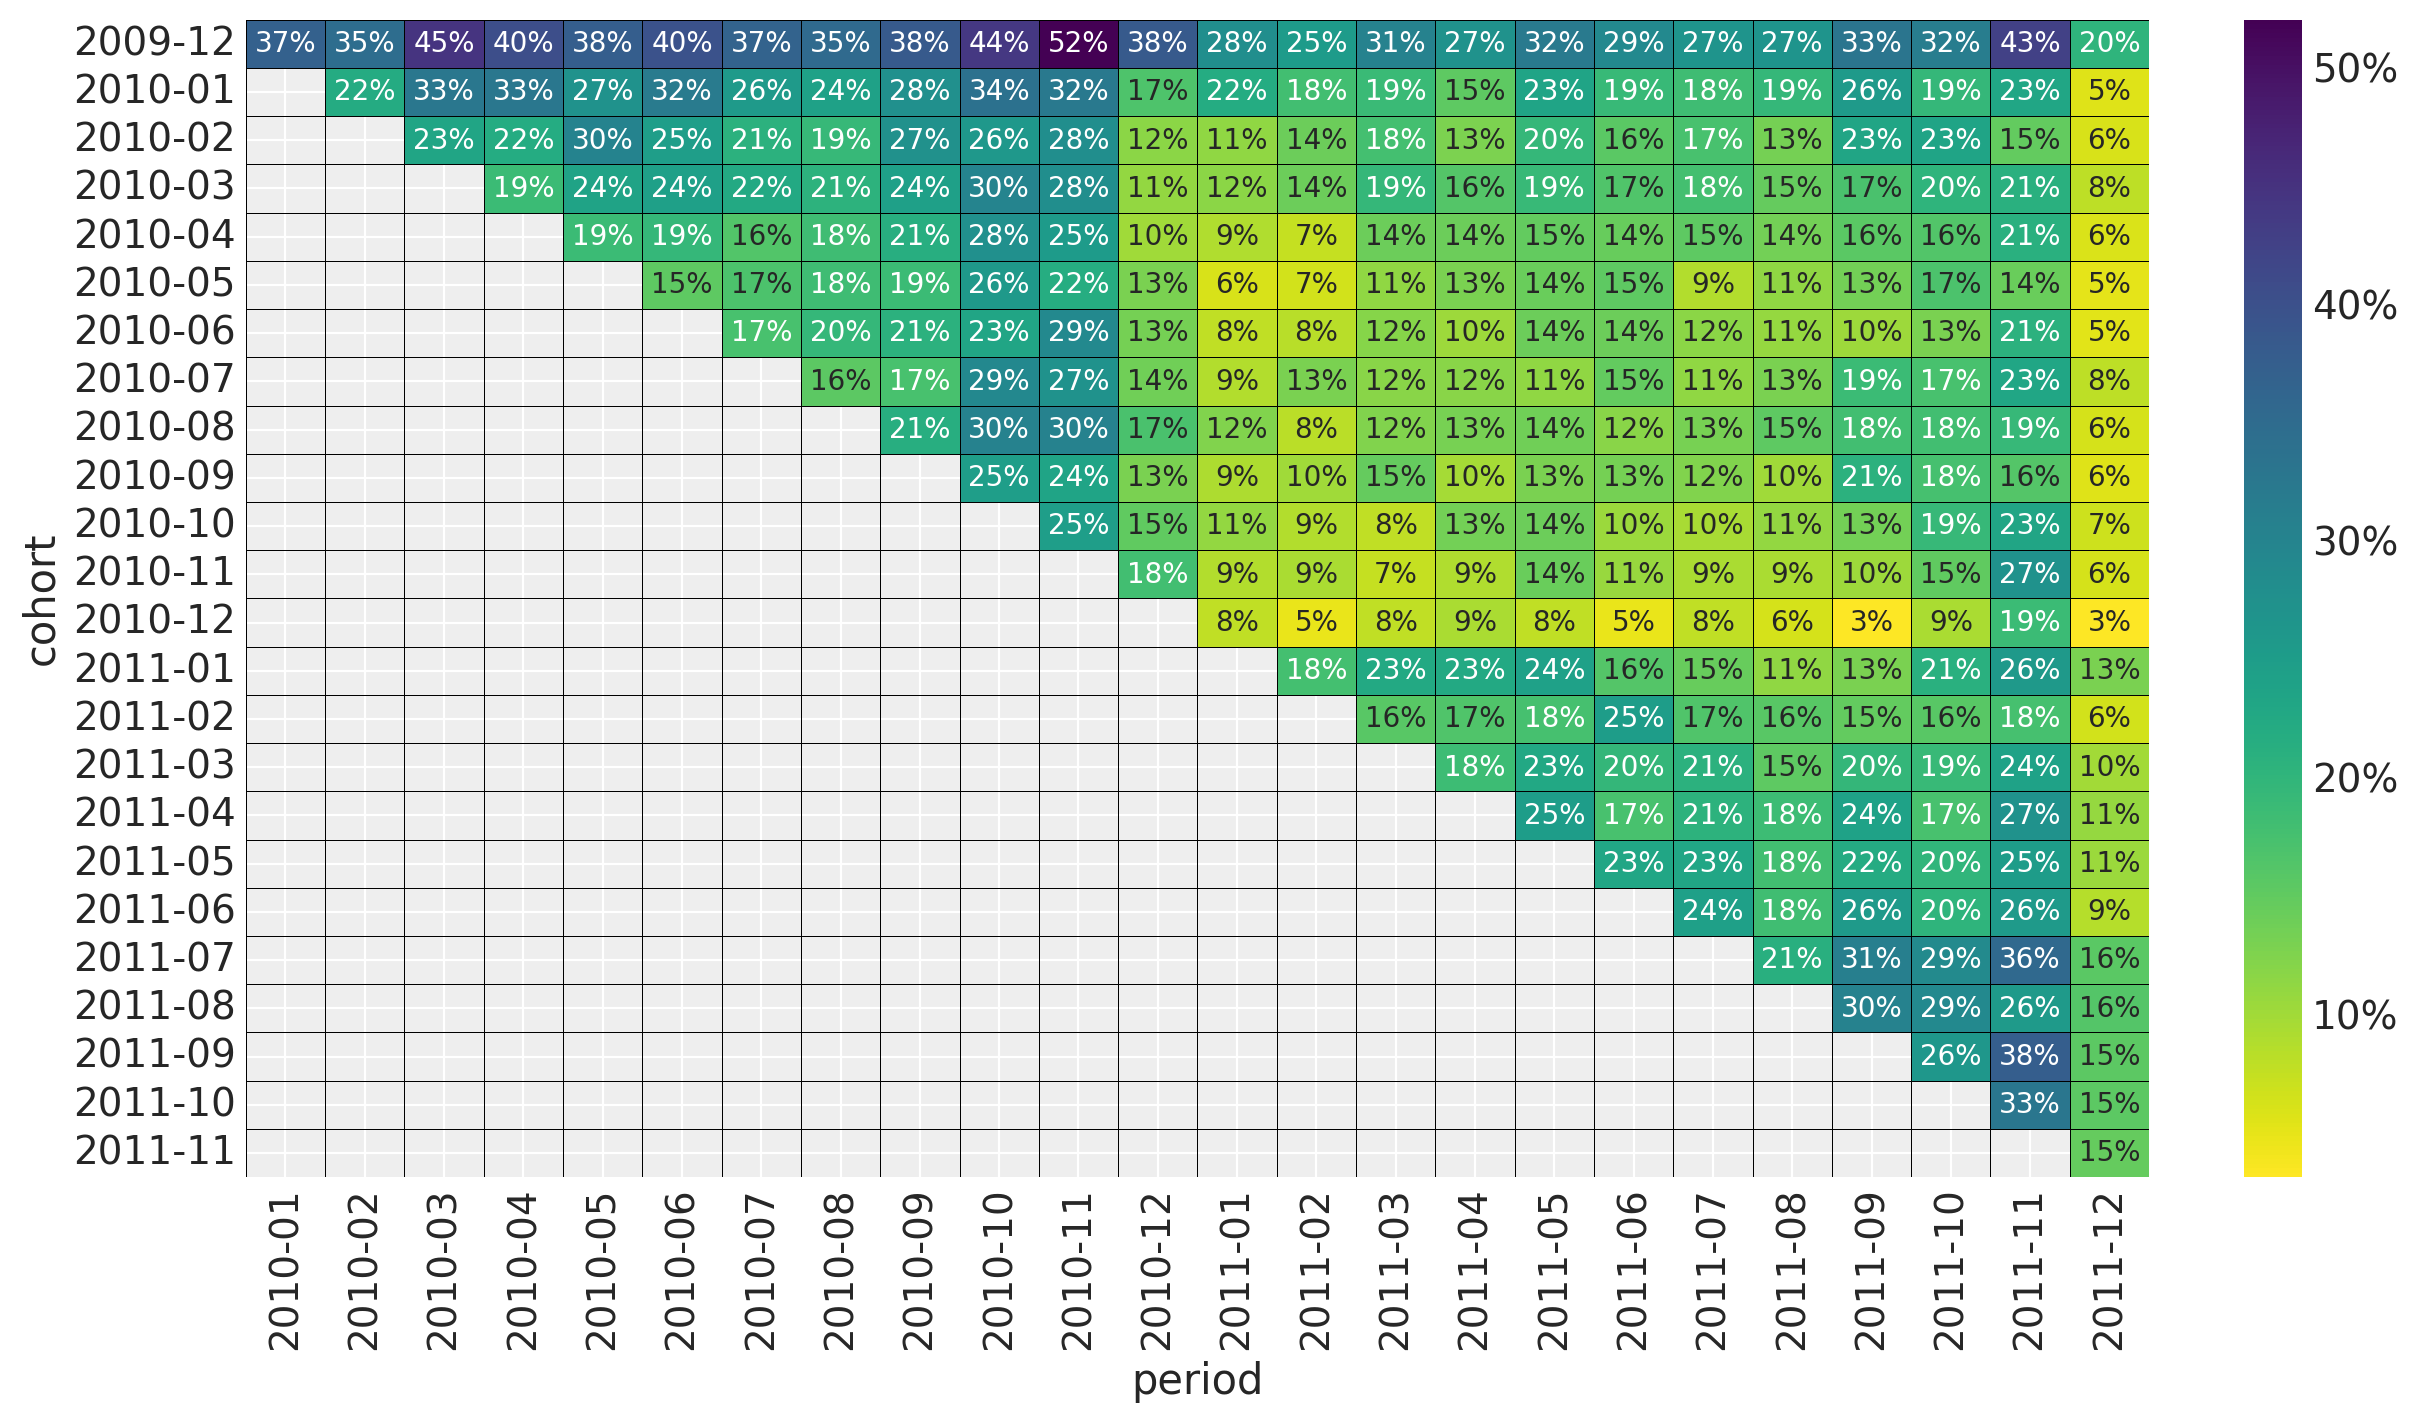

In [167]:
fig, ax = plt.subplots()

(
    uk_cohorts_df.assign(
        cohort=lambda df: df["cohort"].dt.strftime("%Y-%m"),
        period=lambda df: df["period"].dt.strftime("%Y-%m"),
    )
    .query("cohort < period")
    .pivot_table(index="cohort", columns="period", values="retention")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        linewidths=0.2,
        linecolor="black",
        annot=True,
        fmt="0.0%",
        cbar_kws={"format": mtick.FuncFormatter(func=lambda y, _: f"{y :0.0%}")},
        ax=ax,
    )
)

<Axes: xlabel='period', ylabel='cohort'>

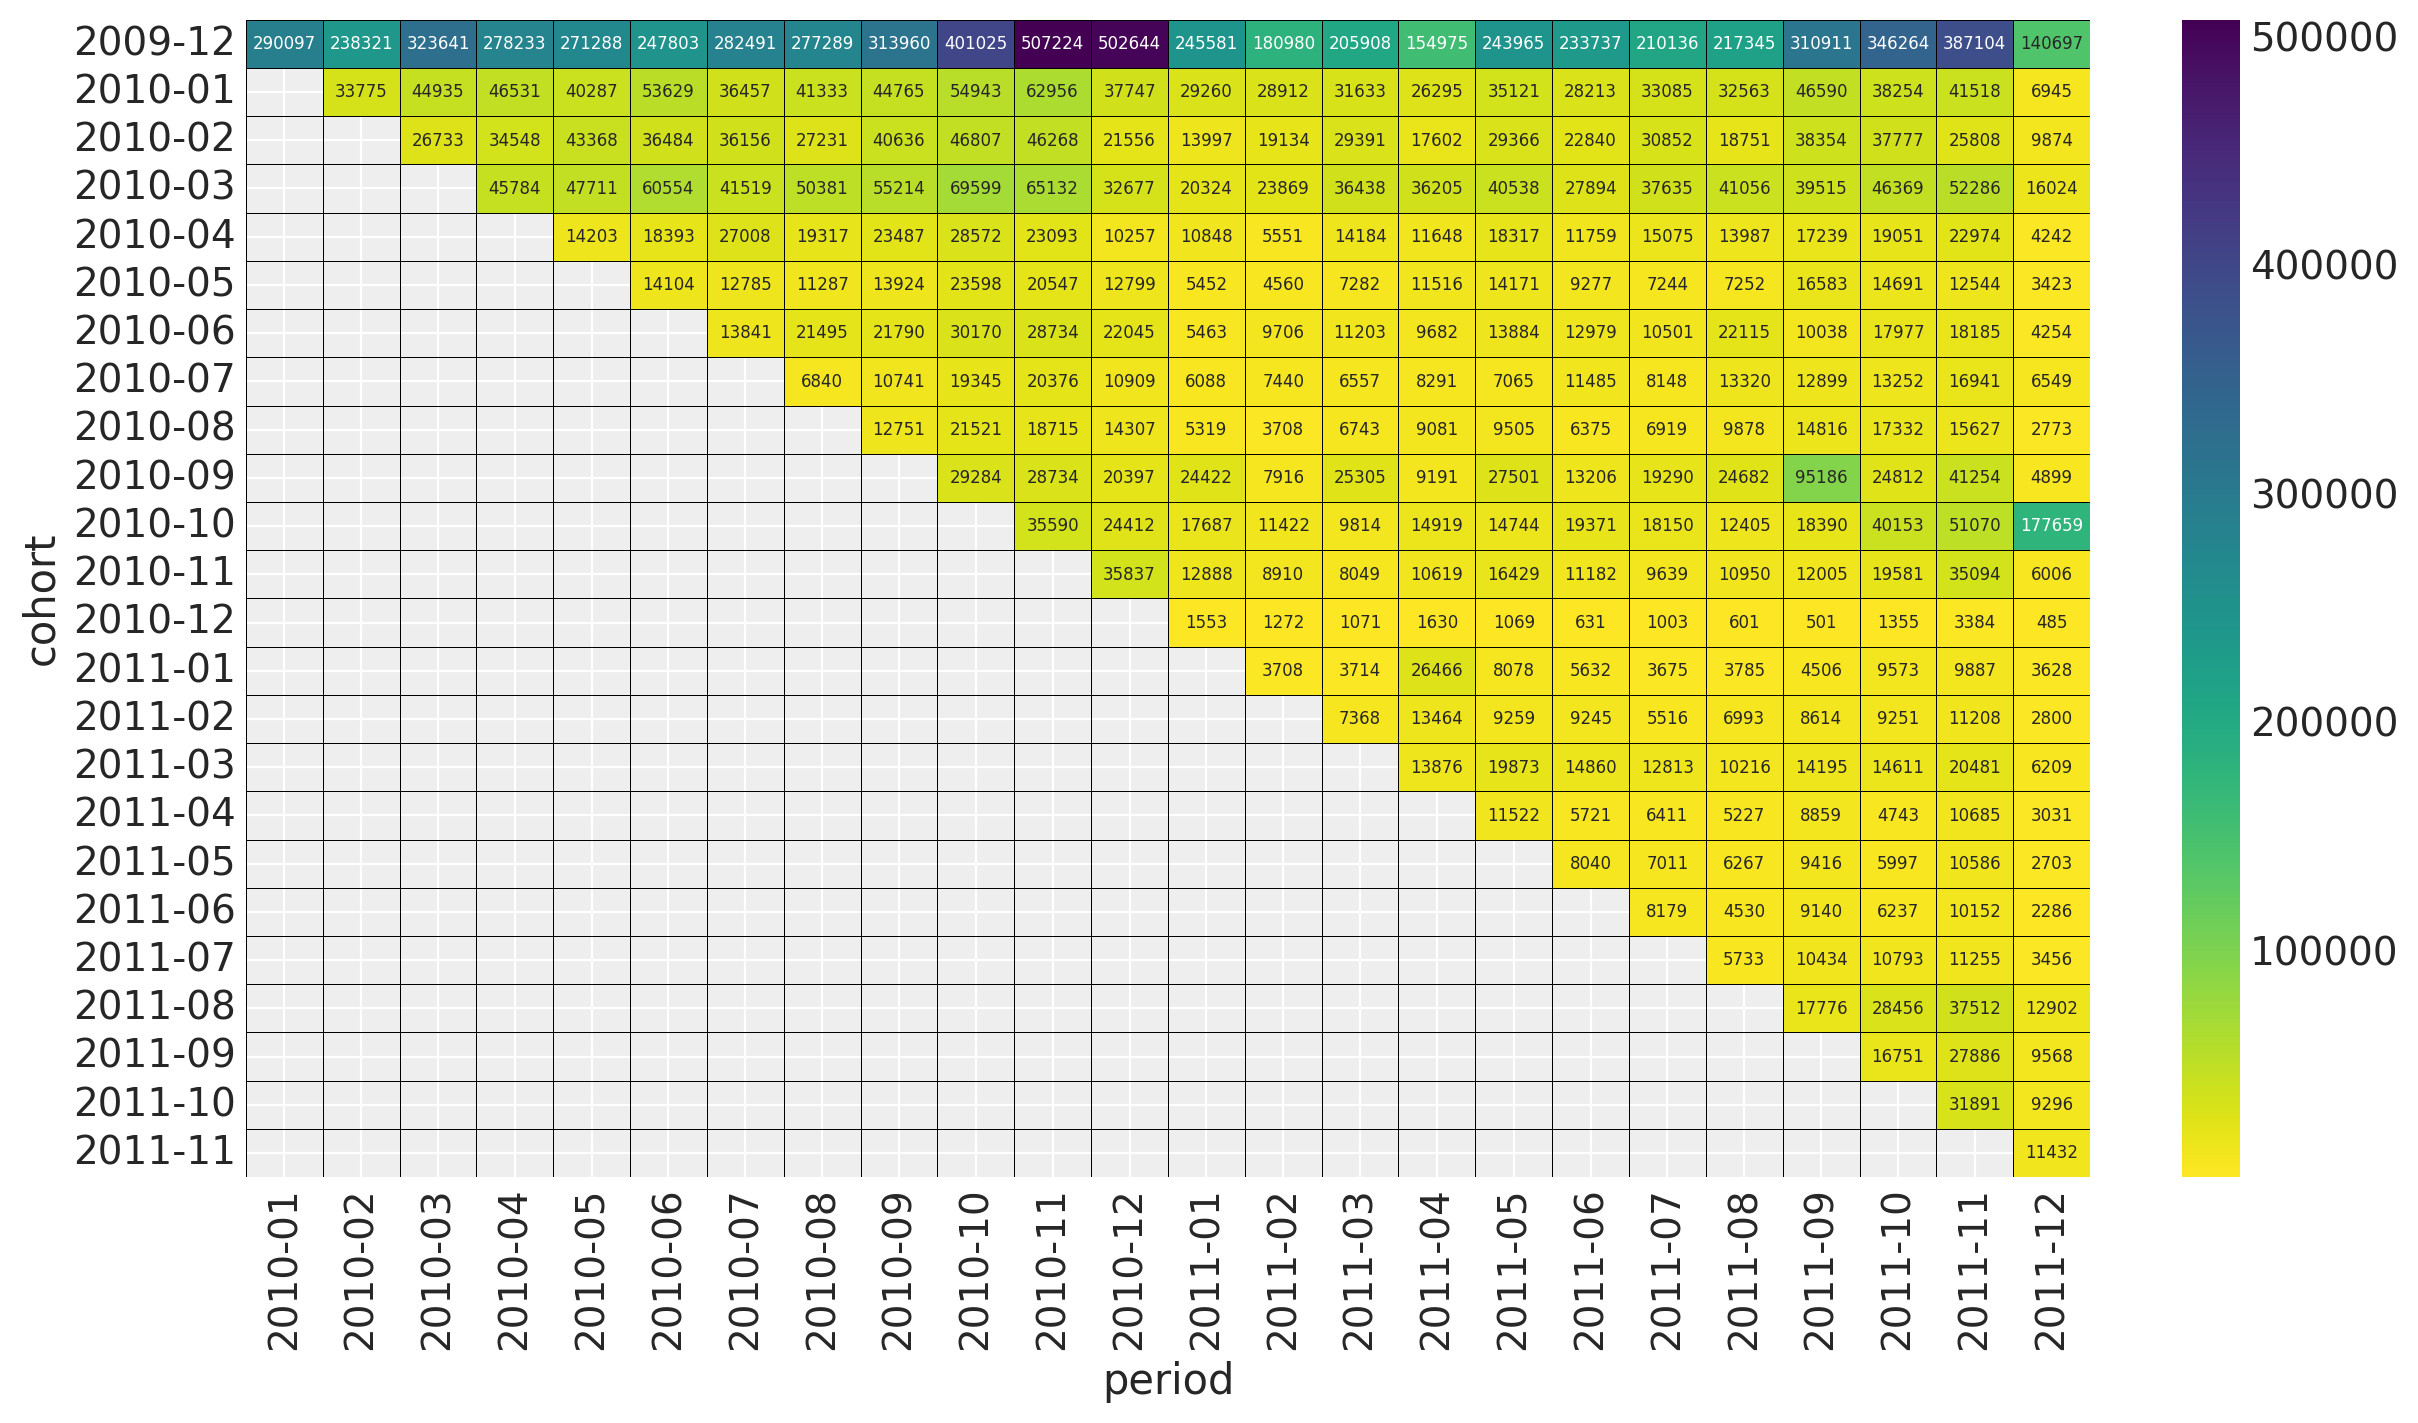

In [163]:
fig, ax = plt.subplots()

(
    uk_cohorts_df.assign(
        cohort=lambda df: df["cohort"].dt.strftime("%Y-%m"),
        period=lambda df: df["period"].dt.strftime("%Y-%m"),
    )
    .query("cohort < period")
    .pivot_table(index="cohort", columns="period", values="revenue")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        linewidths=0.2,
        linecolor="black",
        annot=True,
        annot_kws={"fontsize": 6},
        fmt="0.0f",
        cbar_kws={"format": mtick.FuncFormatter(lambda y, _: f"{y :0.0f}")},
        ax=ax,
    )
)